In [283]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
%matplotlib inline

In [285]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
pd.set_option('mode.chained_assignment',None)
import glob
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import numpy as np
%matplotlib inline

In [286]:
def split_model(df, model_name=None):
  if model_name:
    model_df = df[df.model==model_name]
  else:
    model_df = df.copy()
  td_model_df = model_df[~model_df["mode"].str.contains("baseline")]
  baseline_df = model_df[model_df["mode"].str.contains("baseline")]
  return td_model_df, baseline_df

In [287]:
def make_color_lookup(df, cmap=plt.cm.cool, key="td"):
  unique_tds = np.sort(td_model_df[key].unique())
  cmap_colors = cmap(np.linspace(0, 1, len(unique_tds)+2))[1:-1][:,:3]
  color_lookup = {key: cmap_colors[i] for i, key in enumerate(unique_tds)}
  return color_lookup

In [288]:
def scatter_line_plot(df, ls='-', lw=2, color=None, palette=None, alpha=0.5):
    sns.lineplot(
        x="t", 
        y="val", 
        hue="td", 
        data=df,
        palette=palette, 
        linestyle=ls,
        color=color,
        linewidth=lw,
        alpha=alpha,
    )
    sns.scatterplot(
        x="t", 
        y="val", 
        hue="td",
        data=df,
        palette=palette, 
        color=color,
    )

In [289]:
def set_best_and_asymptotic_vals(df, title, show_best=False, val_at_t=3, add_auc=False):
  auc_str = ""
  if add_auc:
    vals = np.array(df.val)
    auc_val = np.trapz(vals) / np.trapz([100 for _ in vals])
    auc_str = f", AUC={auc_val:0.4f}"

  best_val = df.val.max()
  best_t = df.loc[df.val.idxmax()].t
  asymptotic_val = df[df.t==df.t.max()].val.iloc[0]
  asym_str = f"{asymptotic_val:0.3f}% (asym)"
  t_val_str = ""
  if val_at_t is not None:
    t_val = df[df.t==val_at_t].val.iloc[0]
    t_val_str = f", {t_val:0.3f}% @ t={val_at_t}"
  if show_best:
    best_str = f", {best_val:0.3f}% @ t={best_t}"
  else:
    best_str = ""
  df["td"] = [
      f"{title}: {asym_str}{best_str}{t_val_str}{auc_str}" 
      for td_key in df["td"]
  ]

In [290]:
def plot_figure(
    td_model_df, 
    dataset_name,
    baseline_df=None, 
    ylim_min=None, 
    ylim_max=None, 
    use_best=True,
    show_dist=False,
    legend_font_size=6,
    val_at_t=3,
    show_td_1_only=False,
    dist_cmap=plt.cm.Reds,
    dist_ls="--",
    add_auc=False,
    key_val=None,
    key="td",
  ):
  plt.figure(figsize=(8,3))
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  
  dist_model_df = td_model_df[td_model_df.distillation]
  td_model_df = td_model_df[~td_model_df.distillation]
  
  n_remove = 0
  if len(td_model_df):
    n_remove += td_model_df[key].unique().shape[0]
    model_name = td_model_df.model.iloc[0]
    color_lookup = make_color_lookup(td_model_df, key=key)
  
    # TD Model curves
    for td_key, td_df in td_model_df.groupby(key):
      if key == "td":
        title = f"TD({td_key:0.2f})"
      else:
        title = r"$\alpha$={:0.2f}".format(td_key)
        
      set_best_and_asymptotic_vals(
          td_df, 
          title=title,
          val_at_t=val_at_t,
      )
      color = color_lookup[td_key]
      palette = sns.set_palette(sns.color_palette([color]))
      scatter_line_plot(td_df, palette=palette, lw=2.5, ls="-")
  else:
    model_name = dist_model_df.model.iloc[0]
  g = plt.gca()
  
  if show_dist and len(dist_model_df):
    if show_td_1_only:
      n_remove += 1
    else:
      n_remove += dist_model_df[key].unique().shape[0]
    color_lookup = make_color_lookup(dist_model_df, cmap=dist_cmap, key=key)
    for td_key, dist_td_df in dist_model_df.groupby(key):
      if show_td_1_only and td_key != 1:
        continue
      
      if key == "td":
        title = f"Fast Pose CVPR 2019, TD({td_key:0.2f})"
      else:
        title = r"Fast Pose CVPR 2019, $\alpha$={:0.2f}".format(td_key)
        
      set_best_and_asymptotic_vals(
          dist_td_df, 
          title=title, # f"Fast Pose CVPR 2019, TD({td_key:0.2f})",
          val_at_t=val_at_t,
          add_auc=add_auc,
      )
      if show_td_1_only:
        color = [0.0, 0.0, 0.0]
      else:
        color = color_lookup[td_key]
      palette = sns.set_palette(sns.color_palette([color]))
      scatter_line_plot(dist_td_df, palette=palette, lw=2, ls=dist_ls, alpha=0.5)
  
  if baseline_df is not None:
    n_remove += 1
    set_best_and_asymptotic_vals(baseline_df, title="4-Stack Small")
    palette = sns.set_palette(sns.color_palette([[0.0, 0.0, 0.0]]))
    scatter_line_plot(baseline_df, color="black", lw=2, ls="--", alpha=0.5)
    
  handles, labels = g.get_legend_handles_labels()
  handles = handles[:-n_remove]
  labels = labels[:-n_remove]
  leg = plt.legend(handles, labels, loc="lower right", prop={'size': legend_font_size})
  
  if show_dist and len(dist_model_df):
    leg_lines = leg.get_lines()
    last_n = dist_model_df[key].unique().shape[0]
    n_lines = len(leg_lines)
    leg_is = list(range(n_lines-last_n, n_lines))
    for leg_i in leg_is:
      leg_lines[leg_i].set_linestyle(dist_ls)
    
  title = f"{model_name.capitalize()}, {dataset_name.upper()} Validation Set"
  if key_val is not None:
    key_title = r"$\lambda$" if key == "alpha" else r"$\alpha$"
    title = f"{title}, {key_title}={key_val:0.2f}"
  g.set_title(title, fontsize=10)
  g.set_xlabel("Timestep, t")
  g.set_ylabel("Accuracy (%)")
  g.xaxis.set_major_locator(MaxNLocator(integer=True))
  
  if ylim_max:
    plt.ylim(ylim_min, ylim_max)

In [291]:
figs_root = "figs"
if not os.path.exists(figs_root):
  os.makedirs(figs_root)

In [292]:
DATASET_NAME = "mpii"  # mpii, coco

root = f"/hdd/mliuzzolino/TDPoseEstimation/results/{DATASET_NAME}"
all_result_paths = glob.glob(f"{root}/*/*")
all_result_paths

['/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_1.0/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_1.0__distill__TD_1.0/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.0__double/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.5/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.5__double/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.5__distill__TD_0.5/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.9/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.25/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.9__double/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x4__TD_0.0__distill__TD_0.0/result__0.5.npy',
 '/hdd/mliuzzolino/TDPoseEstimation/results/

In [293]:
df_dict = defaultdict(list)
for path in all_result_paths:
  result = np.load(path)
  if not result.shape:
    result = [result]
  basename = os.path.basename(os.path.dirname(path))
  exp_name = "TD" + basename.split("__TD")[1]

  if "distill" in basename:
    distillation = True
    teacher_td = basename.split("__distill__TD_")[1]
    student_td = basename.split("__distill__TD_")[0].split("__TD_")[1]
    exp_name += f"__TD_{teacher_td}"
  else:
    distillation = False
    if "double" in basename:
      teacher_td = basename.split("__TD_")[1].split("__double")[0]
      student_td = "y"
    else:
      teacher_td = "y"
      student_td = basename.split("__TD_")[1].split(".yaml")[0]
  
  
  for t, val in enumerate(result):
    df_dict["exp_name"].append(exp_name)
    df_dict["t"].append(t)
    df_dict["val"].append(val)
    df_dict["distillation"].append(distillation)
    df_dict["student_td"].append(student_td)
    df_dict["teacher_td"].append(teacher_td)
df = pd.DataFrame(df_dict)

In [294]:
def annotate_plot(
  g, 
  annot_text,
  annot_x=0.335, 
  annot_y=0.85,
  widthB=8.9,
  annot_lw=3.0,
  annot_color="r",
  text_dy = 0.01,
):

  g.annotate(
    annot_text, 
    xy=(annot_x, annot_y), 
    xytext=(annot_x, annot_y+text_dy), 
    xycoords="axes fraction", 
    fontsize=10, 
    ha="center", 
    va="bottom",
    bbox=dict(
      boxstyle="square", 
      fc="white", 
      color=annot_color, 
      lw=annot_lw
    ),
    arrowprops=dict(
      arrowstyle=f"-[, widthB={widthB}, lengthB=1.5", 
      lw=annot_lw,
      color=annot_color,
    )
  )


# Asymptotic

In [295]:
df_dict = defaultdict(list)
for exp_name, df_i in df.groupby("exp_name"):
  df_i.sort_values("t", inplace=True)
  acc_vals = np.array(df_i.val)
  asymp_val = acc_vals[-1]
  df_dict["exp_name"].append(exp_name)
  df_dict["teacher_td_lambda"].append(df_i.teacher_td.iloc[0])
  df_dict["student_td_lambda"].append(df_i.student_td.iloc[0])
  df_dict["asymp"].append(asymp_val)
asymp_df = pd.DataFrame(df_dict)

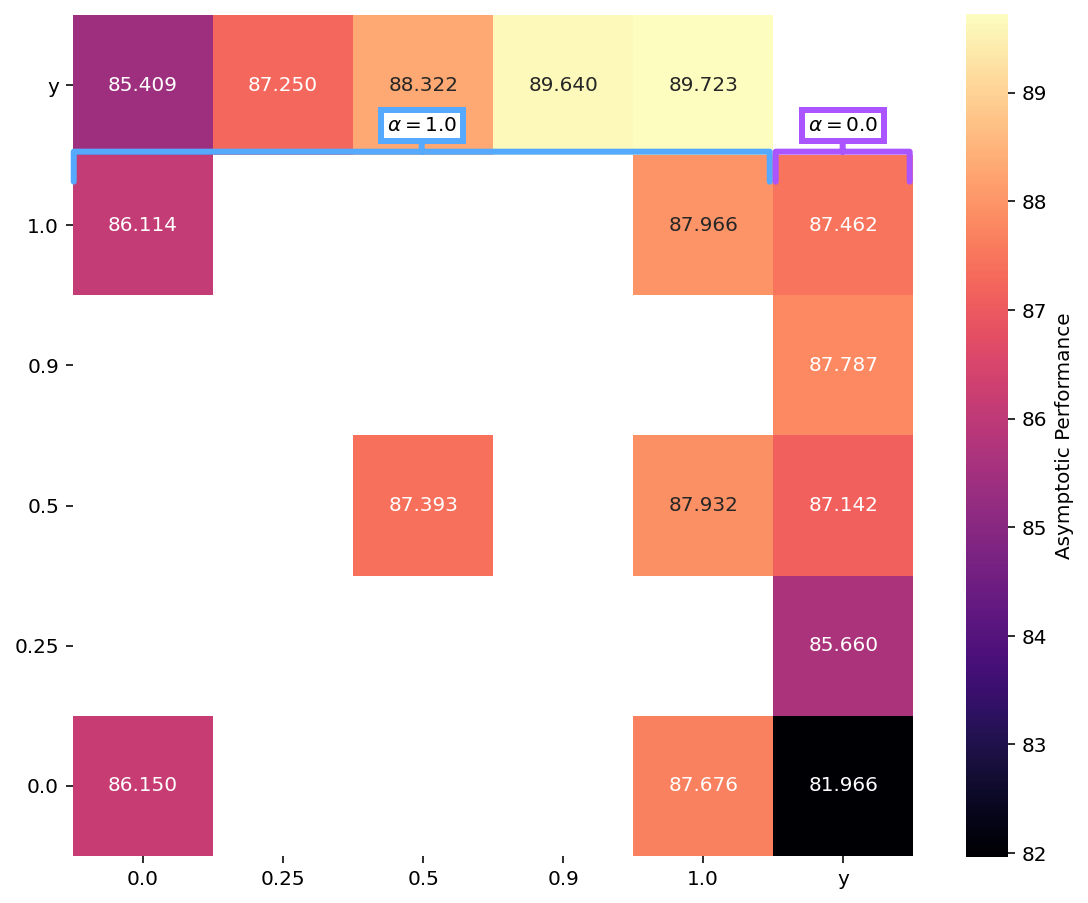

In [296]:
VMIN = None
VMAX = None
CBAR_SHRINK_FACTOR = 0.76
TRANSPOSE = True
plt.figure(figsize=(8,8))

# Pivot table
result = asymp_df.pivot(
  index="teacher_td_lambda", 
  columns="student_td_lambda", 
  values="asymp"
).T


# Resort columns
# cols = np.roll(result.columns.tolist(), -1)
# result = result[cols]

# Resort rows
result = result.iloc[::-1]
result = result.loc[result.index]


VMAX = None # result.iloc[1:].values.max()

# Mask
mask = np.zeros_like(result)
mask[np.where(result==0)] = True


g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.3f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "Asymptotic Performance", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
    vmax=VMAX,
)

annot_y = 0.833
text_dy = 0.025
annot_cmap = plt.cm.cool(np.linspace(0, 1, 2+2))[1:-1]
annot_color = "gray"
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=1.0$", 
  annot_x=0.415, 
  annot_y=annot_y, 
  widthB=17.4,
  annot_color=annot_cmap[0],
  text_dy=text_dy,
)
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=0.0$", 
  annot_x=0.916, 
  annot_y=annot_y, 
  widthB=3.35,
  annot_color=annot_cmap[1],
  text_dy=text_dy,
)
g.set(xlabel="", ylabel="")
plt.yticks(rotation=0)
plt.tight_layout()


pdf_save_path = os.path.join(figs_root, "asymptotic_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

# AUC

In [297]:
df_dict = defaultdict(list)
for exp_name, df_i in df.groupby("exp_name"):
  df_i.sort_values("t", inplace=True)
  acc_vals = np.array(df_i.val)
  t_vals = np.array(df_i.t)
  auc = np.trapz(acc_vals, t_vals) / np.trapz([100 for _ in acc_vals]) * 100
  df_dict["exp_name"].append(exp_name)
  df_dict["teacher_td_lambda"].append(df_i.teacher_td.iloc[0])
  df_dict["student_td_lambda"].append(df_i.student_td.iloc[0])
  df_dict["auc"].append(auc)
auc_df = pd.DataFrame(df_dict)

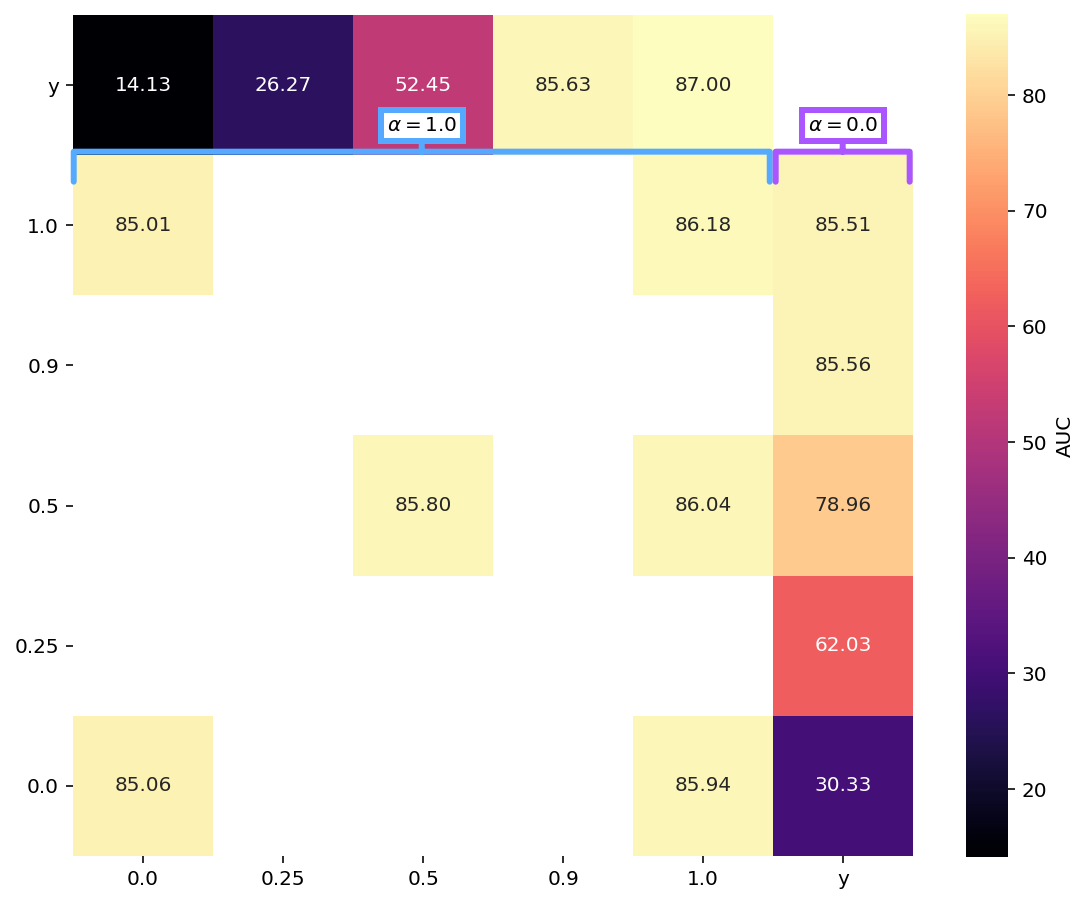

In [298]:
VMIN = None
VMAX = None
CBAR_SHRINK_FACTOR = 0.76
TRANSPOSE = True
plt.figure(figsize=(8,8))

# Pivot table
result = auc_df.pivot(
  index="teacher_td_lambda", 
  columns="student_td_lambda", 
  values="auc"
).T

# Resort rows
result = result.iloc[::-1]
result = result.loc[result.index]

VMAX = None # result.iloc[1:].values.max()

# Mask
mask = np.zeros_like(result)
mask[np.where(result==0)] = True


g = sns.heatmap(
    result, 
    mask=mask,
    annot=True, 
    fmt="0.2f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "AUC", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
    vmax=VMAX,
)


annot_y = 0.833
text_dy = 0.025
annot_cmap = plt.cm.cool(np.linspace(0, 1, 2+2))[1:-1]
annot_color = "gray"
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=1.0$", 
  annot_x=0.415, 
  annot_y=annot_y, 
  widthB=17.4,
  annot_color=annot_cmap[0],
  text_dy=text_dy,
)
annotate_plot(
  g=g, 
  annot_text=r"$\alpha=0.0$", 
  annot_x=0.916, 
  annot_y=annot_y, 
  widthB=3.35,
  annot_color=annot_cmap[1],
  text_dy=text_dy,
)


g.set(xlabel="", ylabel="")
plt.yticks(rotation=0)
plt.tight_layout()

pdf_save_path = os.path.join(figs_root, "auc_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)